In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch.backends.cudnn as cudnn

from tqdm import tqdm 

import psweep as ps

In [2]:
import sys
sys.path.append('../code/utils')  # Add the utils directory to the Python path
import utils_data, utils_spikes, utils_events, utils_tensor, utils_pcn 

sys.path.append('../code/models')  # Add the models directory to the Python path
import pcn

# Let's burn some GPUs over the last weekend of the workshop

# Fixed parameters

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
cudnn.benchmark = True

In [ ]:
# Input parameters
batch_size = 32  # Batch size
norm_factor = 1  # Normalization factor

# Learning parameters
epochs = 2  # should be enough given the 07-07 notebook
n_inferences_steps = 500  # number of inference steps per input
n_generative_steps = 500 # number of generative steps per input

# Layer parameter
update_weights_flag = True  # whether to learn the FF weights
f = utils_pcn.tanh
df = utils_pcn.tanh_deriv

# Torch parameters 
num_workers = 18
pin_memory = True

fixed_predictions = True  # change the predictions or not
weight_clamp = 50  # weight clamp
mu_clamp = 1000  # value neuron clamp

# Writing the scanning function

In [8]:
def train_pcnet(params) :
        
    theta_lr = params['theta_lr']
    mu_lr = params['mu_lr']
    L1_size = params['L1_size']
    L2_size = params['L2_size']
    L3_size = params['L3_size']
    
    # Generating datasets
    transform = transforms.Compose([transforms.ToTensor()])

    trainset = torchvision.datasets.MNIST(root='./data/mnist_data', train=True,
                                        download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers = num_workers, pin_memory = pin_memory)

    testset = torchvision.datasets.MNIST(root='./data/mnist_data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=True, num_workers = num_workers, pin_memory = pin_memory)

    testset = list(iter(testloader)) # this is just because I did a terrible implementation of PCNet
    trainset = list(iter(trainloader))

    for i, (img, label) in enumerate(trainset[:-2]) :
        trainset[i] = (torch.Tensor(img).reshape(len(img), 784).to(torch.float64), label)
        
    for i, (img, label) in enumerate(testset[:-2]) :
        testset[i] = (torch.Tensor(img).reshape(len(img), 784).to(torch.float64), label)

    # Building the network
    shapes = [trainset[0][0].shape[1], L1_size, L2_size, L3_size, 10]
    layers = []
    for i in range(len(shapes)-1) :
        print('Layer', i, ' : ', shapes[i], ' -> ', shapes[i+1])
        layers.append(pcn.FCLayer(input_size = shapes[i],
                                output_size = shapes[i+1], f = f, df = df,
                                device = device))
        

    model = pcn.PCNet_Bogacz(layers = layers, batch_size = batch_size,
                            n_inferences_steps = n_inferences_steps,
                            mu_lr = mu_lr, theta_lr = theta_lr, pi_lr = 42,
                            fixed_predictions = fixed_predictions, update_weights_flag=update_weights_flag,
                            weight_clamp = weight_clamp, mu_clamp = mu_clamp,  pi_clamp = 42,
                            device = device, do_pi = False)

    # GPU burning
    losses, accs, test_accs = pcn.train(model = model, 
                                    trainset = trainset[0:-2], testset = testset[0:-2],
                                    n_epochs = epochs)

    utils_pcn.plot_loss_accs(losses, accs, test_accs)
    
    # And generative mode 
    one_hot_matrix = torch.eye(10, device = device)
    labels = torch.randint(10, size = (batch_size,), device = device)
    one_hot_vectors = one_hot_matrix[labels]
    gen_imgs = model.hard_generate(y = one_hot_vectors, 
                                n_generative_steps = n_generative_steps) 
    
    fig, axs = plt.subplots(figsize = (10,10), ncols = np.sqrt(batch_size).astype(int), nrows = np.sqrt(batch_size).astype(int))
    for iax, ax in enumerate(axs.flatten()) :
        ax.imshow(gen_imgs[iax,:].reshape(28,28).cpu().detach().numpy(), cmap = 'gray')
        ax.axis('off')
    plt.show()
    
    return losses, accs, test_accs, gen_imgs 

Layer 0  :  784  ->  512
Layer 1  :  512  ->  256
Layer 2  :  256  ->  512
Layer 3  :  512  ->  10


Training ...: 100%|██████████| 3/3 [18:56<00:00, 378.85s/it]


# And let's run the scan 

In [ ]:
# Make multiple possible size for the input layers
size_hiddens = np.linspace(512, 128, 2, dtype=int)
# Generate all possible combinations for 1, 2, and 3 layers.
hidden_layer_sizes_1 = [[size] for size in size_hiddens]
hidden_layer_sizes_2 = [[size1, size2] for size1 in size_hiddens for size2 in size_hiddens]
hidden_layer_sizes_3 = [[size1, size2, size3] for size1 in size_hiddens for size2 in size_hiddens for size3 in size_hiddens]
num_hiddens = ps.plist("num_hiddens", hidden_layer_sizes_1 + hidden_layer_sizes_2 + hidden_layer_sizes_3)

theta_lrs = ps.plist("theta_lr", [5e-3, 5e-4, 5e-5])
mu_lrs = ps.plist("mu_lr", [2e-2, 2e-3, 2e-4])

theta_lrs = ps.plist("theta_lr", [5e-3, 5e-4, 5e-5][0])
mu_lrs = ps.plist("mu_lr", [2e-2, 2e-3, 2e-4][0])

# Create the parameter grid
param_grid = ps.pgrid((num_hiddens, theta_lrs, mu_lrs))

# Define a function to run one instance of the experiment
def run_experiment(params):
    losses, accs, test_accs, gen_imgs = train_pcnet(params)
    return {'losses': losses, 'accs': accs, 'test_accs': test_accs, 'gen_imgs': gen_imgs}

print("Running parameter sweep of length {}.".format(len(param_grid)))

# Run the parameter sweep
results = ps.run_local(run_experiment, param_grid, verbose = True)

# Generative mode now

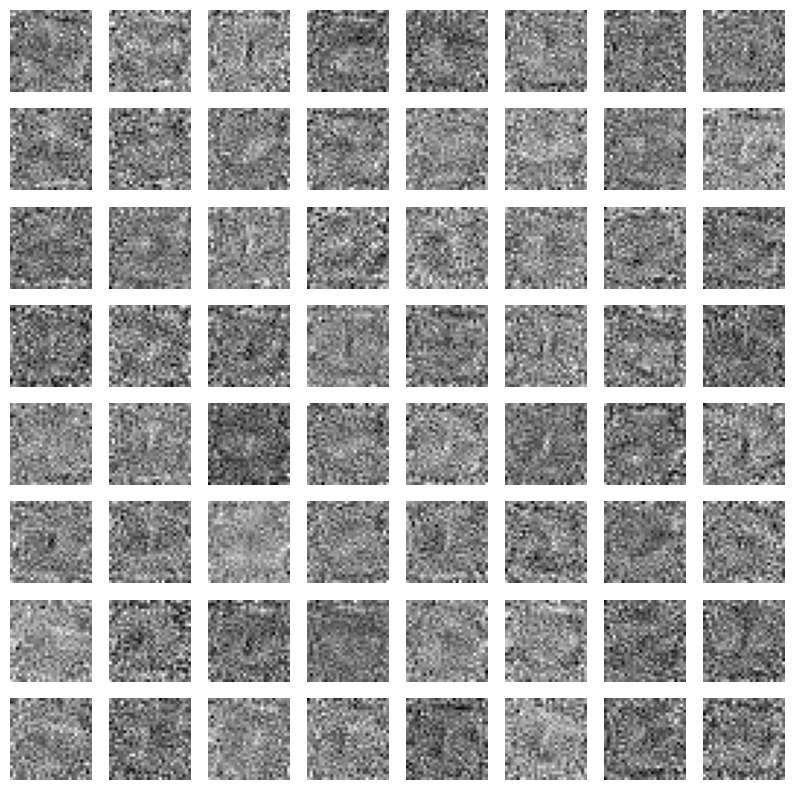